# 13 - Quantum Bayesian Inference

In [1]:
# This code is at:
# https://qiskit-community.github.io/qiskit-machine-learning/tutorials/13_quantum_bayesian_inference.html

In [2]:
# Include libraries
import numpy as np

# Define rotation angles
theta_X = 2 * np.arcsin(np.sqrt(0.2))
theta_Y_X = 2 * np.arcsin(np.sqrt(0.9))
theta_Y_nX = 2 * np.arcsin(np.sqrt(0.3))

In [3]:
theta_B = 2 * np.arcsin(np.sqrt(0.001))
theta_E = 2 * np.arcsin(np.sqrt(0.002))
theta_A_nBnE = 2 * np.arcsin(np.sqrt(0.001))
theta_A_nBE = 2 * np.arcsin(np.sqrt(0.29))
theta_A_BnE = 2 * np.arcsin(np.sqrt(0.94))
theta_A_BE = 2 * np.arcsin(np.sqrt(0.95))
theta_J_nA = 2 * np.arcsin(np.sqrt(0.05))
theta_J_A = 2 * np.arcsin(np.sqrt(0.9))
theta_M_nA = 2 * np.arcsin(np.sqrt(0.9))
theta_M_A = 2 * np.arcsin(np.sqrt(0.3))

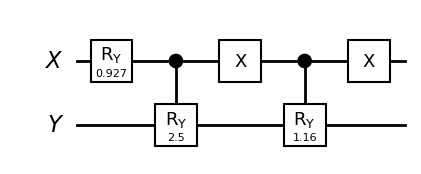

In [4]:
from qiskit import QuantumRegister
from qiskit import QuantumCircuit

# Define quantum registers
qrX = QuantumRegister(1, name="X")
qrY = QuantumRegister(1, name="Y")
# Define a 2-qubit quantum circuit
qc_2n = QuantumCircuit(qrX, qrY, name="Bayes net small")
# Apply the R_Y_theta rotation gate on the first qubit
qc_2n.ry(theta_X, 0)
# Apply the controlled-R_Y_theta rotation gate
qc_2n.cry(theta_Y_X, control_qubit=qrX, target_qubit=qrY)
# Apply the X gate on the first qubit
qc_2n.x(0)
# Apply the controlled-R_Y_theta rotation gate
qc_2n.cry(theta_Y_nX, control_qubit=qrX, target_qubit=qrY)
# Apply another X gate on the first qubit
qc_2n.x(0)
qc_2n.draw("mpl", style="bw", plot_barriers=False, justify="none", fold=-1)

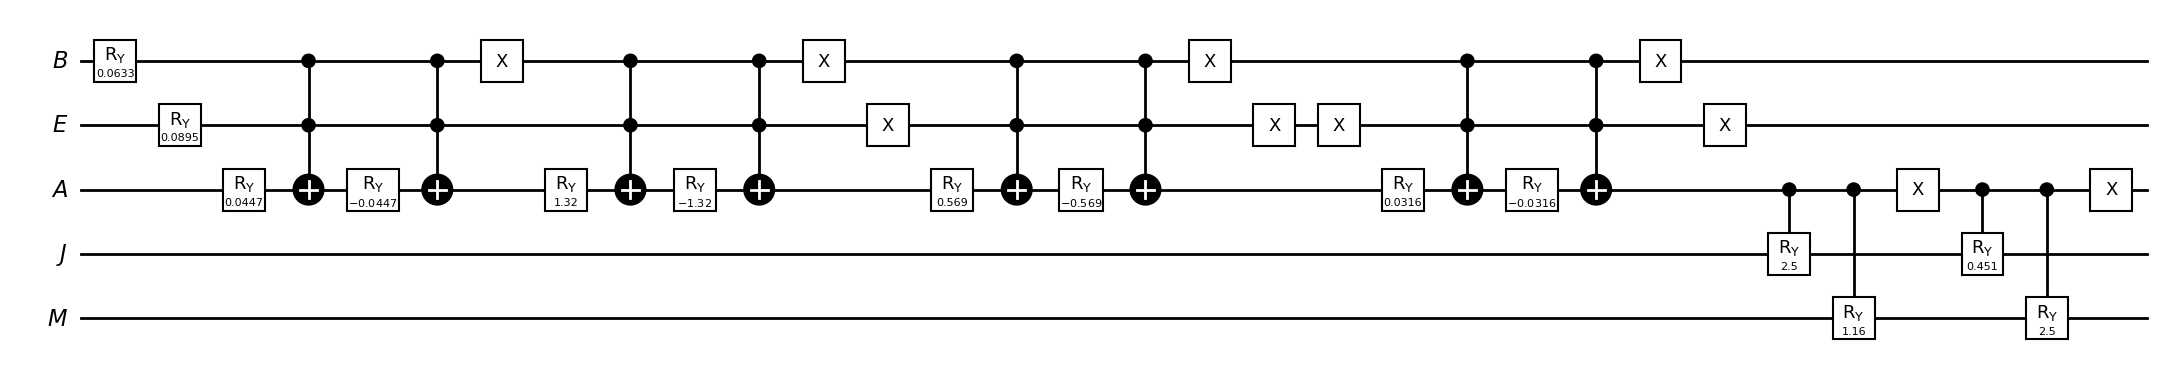

In [5]:
# Initialize register
var = ["B", "E", "A", "J", "M"]
qr = [QuantumRegister(1, name=v) for v in var]
qc_ba = QuantumCircuit(*qr, name="State preparation")
# Specify control qubits
# P(B)
qc_ba.ry(theta_B, qr[0])
# P(E)
qc_ba.ry(theta_E, qr[1])
# P(A|B,E)
qc_ba.mcry(theta_E, [qr[0][0], qr[1][0]], qr[2])
# P(A|-B,E)
qc_ba.x(qr[0])
qc_ba.mcry(theta_A_BnE, [qr[0][0], qr[1][0]], qr[2])
qc_ba.x(qr[0])
# P(A|B,-E)
qc_ba.x(qr[1])
qc_ba.mcry(theta_A_nBE, [qr[0][0], qr[1][0]], qr[2])
qc_ba.x(qr[1])
# P(A|-B,-E)
qc_ba.x(qr[0])
qc_ba.x(qr[1])
qc_ba.mcry(theta_A_nBnE, [qr[0][0], qr[1][0]], qr[2])
qc_ba.x(qr[0])
qc_ba.x(qr[1])
# P(J|A)
qc_ba.cry(theta_J_A, qr[2], qr[3])
# P(M|A)
qc_ba.cry(theta_M_A, qr[2], qr[4])
# P(J|-A) + P(M|-A)
qc_ba.x(qr[2])
qc_ba.cry(theta_J_nA, qr[2], qr[3])
qc_ba.cry(theta_M_nA, qr[2], qr[4])
qc_ba.x(qr[2])
# Draw circuit
qc_ba.draw("mpl", style="bw", plot_barriers=False, justify="none", fold=-1)

Our Sampler


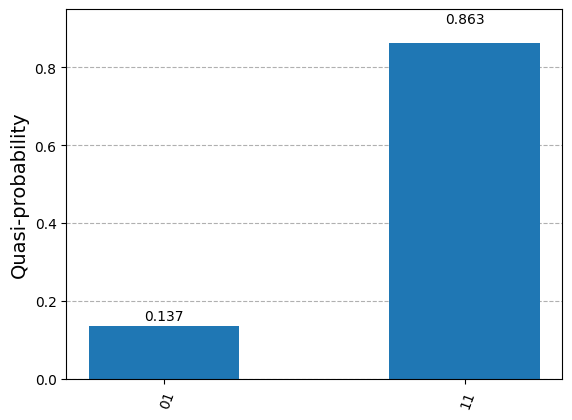

In [6]:
from qiskit_machine_learning.algorithms import QBayesian
from qiskit.visualization import plot_histogram
#from qiskit.primitives import StatevectorSampler as Sampler

from quantumrings.toolkit.qiskit import QrStatevectorSampler as Sampler

sampler = Sampler()
evidence = {"X": 1}
# Initialize QBayesian
qb_2n = QBayesian(circuit=qc_2n, sampler=sampler)
# Sampling
samples = qb_2n.rejection_sampling(evidence=evidence)
plot_histogram(samples)

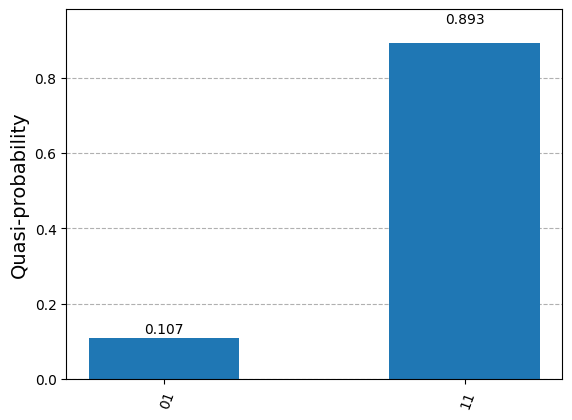

In [7]:
# Sampling
qb_2n.threshold = 0.97
samples = qb_2n.rejection_sampling(evidence=evidence)
plot_histogram(samples)


In [8]:
qb_2n.threshold = 0.97
samples = qb_2n.rejection_sampling(evidence=evidence, format_res=True)
print(samples)

{'P(Y=0|X=1)': 0.111328125, 'P(Y=1|X=1)': 0.888671875}


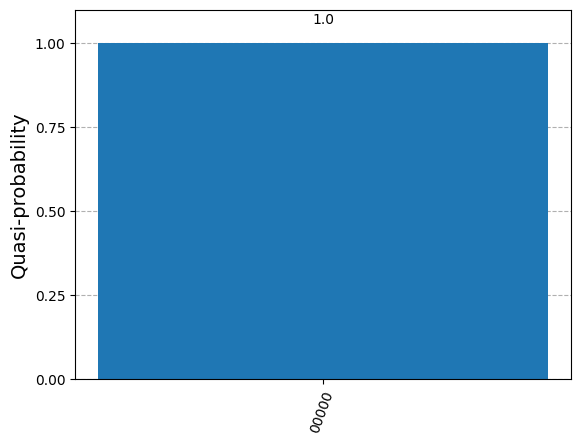

In [9]:
# Initialize quantum bayesian inference framework
qb_ba = QBayesian(circuit=qc_ba, sampler=sampler)
# Inference
counts = qb_ba.rejection_sampling(evidence={})
plot_histogram({c_key: c_val for c_key, c_val in counts.items() if c_val > 0.0001})

In [10]:
query = {"Y": 0}
evidence = {"X": 1}
# Inference
qb_2n.inference(query=query, evidence=evidence)

0.08984375

In [11]:
query = {"B": 1}
evidence = {"J": 1}
# Inference
qb_ba.inference(query=query, evidence=evidence)

0.0

In [12]:
# Inference
qb_ba.threshold = 0.97
qb_ba.inference(query=query, evidence=evidence)

0.0

In [13]:
print("Converged: ", qb_ba.converged)

Converged:  True
